In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam

# from zero to hero
import numpy as np
import pandas as pd
from tqdm import tqdm

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, decomposition, metrics, pipeline

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras.layers import Embedding


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff


import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, make_scorer

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl


2025-07-14 13:34:28.127482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752500068.530671      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752500068.645895      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#loading data
train_data =  pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

# 1. EDA


Let's take look at the first few lines of  the data

In [3]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print(train_data.shape)

(7613, 5)


In [5]:
print(test_data.shape)

(3263, 4)


Visuzling how many Null value we have in each column of the training data

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


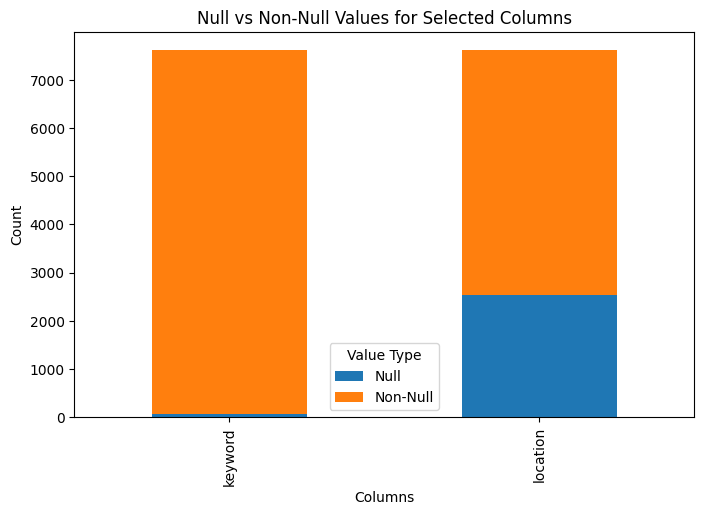

In [7]:
columns_of_interst = ["keyword", "location"]

count_null_df = pd.DataFrame({"Null" : train_data[columns_of_interst].isnull().sum(),
                  "Non-Null": train_data[columns_of_interst].notnull().sum()})

count_null_df.plot(kind='bar', stacked = True, figsize=(8, 5))
plt.title('Null vs Non-Null Values for Selected Columns')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.legend(title='Value Type')
plt.show()

displaying the percentage distribution of target values

In [8]:
count_one = (train_data["target"] == 1).sum()
count_zero = (train_data["target"] == 0).sum()
total_count = len(train_data["target"])

print(f"Percentage of 1's: {((count_one / total_count) * 100):.2f}%")
print(f"Percentage of 0's: {((count_zero / total_count) * 100):.2f}%")

Percentage of 1's: 42.97%
Percentage of 0's: 57.03%


# 2. Natural Language Processing

In [9]:
# I will fill Nan values with "" for now
train_data = train_data.fillna("")

Splitting the training data into dev & train

In [10]:
y = train_data["target"]
X = train_data.drop("target", axis=1)

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
print("X_train_shape : ", X_train.shape, ", X_dev_shape", X_dev.shape)

X_train_shape :  (6090, 4) , X_dev_shape (1523, 4)


## TF-IDF & Bag-of-words

In [12]:
train_text = X_train['keyword'] + ' ' + X_train['location'] + ' ' + X_train['text']
dev_text = X_dev['keyword'] + ' ' + X_dev['location'] + ' ' + X_dev['text']

In [13]:
train_text

4996    military Texas Courageous and honest analysis ...
3263    engulfed  @ZachZaidman @670TheScore wld b a sh...
4907    massacre Cottonwood Arizona Tell @BarackObama ...
2855    drought Spokane, WA Worried about how the CA d...
4716    lava Medan,Indonesia @YoungHeroesID Lava Blast...
                              ...                        
5226    obliteration Merica! @Eganator2000 There aren'...
5390    panic  just had a panic attack bc I don't have...
860     blood  Omron HEM-712C Automatic Blood Pressure...
7603      Officials say a quarantine is in place at an...
7270    whirlwind Stamford & Cork (& Shropshire) I mov...
Length: 6090, dtype: object

In [14]:
tfv = TfidfVectorizer(
    lowercase=True,              
    stop_words='english',        
    max_features=10000,          # Limit to top 10k features by term frequency
    ngram_range=(1, 2),         
    min_df=3,                    
    # max_df=0.8,                  
    norm='l2',                   
    sublinear_tf=True           
)

ctv = CountVectorizer(analyzer='word', stop_words = 'english')

tfv.fit(list(train_text) + list(dev_text))
ctv.fit(list(train_text) + list(dev_text))

X_train_tfv =  tfv.transform(train_text) 
X_dev_tfv = tfv.transform(dev_text)

X_train_ctv =  ctv.transform(train_text) 
X_dev_ctv = ctv.transform(dev_text)

In [15]:
print("X_train_tfv : ", X_train_tfv.shape, ", X_train_ctv: ", X_train_ctv.shape)

X_train_tfv :  (6090, 7758) , X_train_ctv:  (6090, 23211)


# 3. Building Basic Models

We will try using TF-IDF & CTV with some simple models

## Logistic regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

#training LR on tfv
model_tfv = LogisticRegression(max_iter=10000)
model_tfv.fit(X_train_tfv, y_train)
y_pred_tfv = model_tfv.predict(X_dev_tfv)

#training LR on ctv
model_ctv = LogisticRegression(max_iter=10000)
model_ctv.fit(X_train_ctv, y_train)
y_pred_ctv = model_ctv.predict(X_dev_ctv)

print("TF-IDF Classification Report:")
print(classification_report(y_dev, y_pred_tfv))
print("*" * 70)
print("CountVectorizer Classification Report:")
print(classification_report(y_dev, y_pred_ctv))

TF-IDF Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       874
           1       0.79      0.69      0.73       649

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.78      1523

**********************************************************************
CountVectorizer Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       874
           1       0.77      0.70      0.73       649

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



Let's try Naive Bayes

## Naive Bayes

In [17]:
#training on tfv
model_tfv = MultinomialNB()
model_tfv.fit(X_train_tfv, y_train)
y_pred_tfv = model_tfv.predict(X_dev_tfv)

#training on ctv
model_ctv = MultinomialNB()
model_ctv.fit(X_train_ctv, y_train)
y_pred_ctv = model_ctv.predict(X_dev_ctv)

print("TF-IDF Classification Report:")
print(classification_report(y_dev, y_pred_tfv))
print("*" * 70)
print("CountVectorizer Classification Report:")
print(classification_report(y_dev, y_pred_ctv))

TF-IDF Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       874
           1       0.81      0.67      0.73       649

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.79      0.79      1523

**********************************************************************
CountVectorizer Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       874
           1       0.74      0.75      0.75       649

    accuracy                           0.78      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.78      0.78      1523



Approximately the same performance with CountVectorizer, but Naive Bayes performs better with TF-IDF vectorizer, let's try xgboost next !

# 4. Xgboost classifier

In [18]:
#training xgboost on tfv
model_tfv = xgb.XGBClassifier(max_depth=7, n_estimators=200, learning_rate=0.1)

model_tfv.fit(X_train_tfv.tocsc(), y_train)
y_pred_tfv = model_tfv.predict(X_dev_tfv.tocsc())

#training xgboost on ctv
model_ctv = xgb.XGBClassifier(max_depth=7, n_estimators=200, learning_rate=0.1)

model_ctv.fit(X_train_ctv.tocsc(), y_train)
y_pred_ctv = model_ctv.predict(X_dev_ctv.tocsc())

print("TF-IDF Classification Report:")
print(classification_report(y_dev, y_pred_tfv))
print("*" * 70)
print("CountVectorizer Classification Report:")
print(classification_report(y_dev, y_pred_ctv))

TF-IDF Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       874
           1       0.78      0.63      0.70       649

    accuracy                           0.77      1523
   macro avg       0.77      0.75      0.76      1523
weighted avg       0.77      0.77      0.77      1523

**********************************************************************
CountVectorizer Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       874
           1       0.83      0.61      0.71       649

    accuracy                           0.78      1523
   macro avg       0.80      0.76      0.77      1523
weighted avg       0.79      0.78      0.78      1523



Xgboost is currently performing same as the other models. Let's try tuning its hyperparameters to see if we can improve the results

## Grid Search

In [19]:
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False
)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
} 

f1_scorer = metrics.make_scorer(f1_score, average='weighted')

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=3,               
    verbose=1,
    n_jobs=-1           
)

grid_search.fit(X_train_tfv.tocsc(), y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best score parameters: ")
best_parms = grid_search.best_estimator_.get_params()

for param_name in param_grid.keys():
    print("\t%s: %r" % (param_name, best_parms[param_name]))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best score: 0.759
Best score parameters: 
	n_estimators: 200
	learning_rate: 0.1
	max_depth: 7
	subsample: 0.8
	colsample_bytree: 1.0


In [20]:
import pickle

glove_path = "/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl"

with open(glove_path, "rb") as f: 
    glove = pickle.load(f)

## GloVe embeddings

Converting sentences to vectors using GloVe word embeddings

In [21]:
def sentence_to_vec(sentence, glove, dim=300):

    words = sentence.split()
    vectors = [glove.get(word.lower(), np.zeros(dim)) for word in words]

    if len(vectors) == 0:
        return np.zeros(dim)
    
    return np.mean(vectors, axis=0) 

In [22]:
X_train_glove = np.array([sentence_to_vec(s, glove) for s in train_text])
X_dev_glove = np.array([sentence_to_vec(s, glove) for s in dev_text])

In [23]:
model = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=1, 
                        subsample=0.8, nthread=-1, learning_rate=0.1)

model.fit(X_train_glove, y_train)

y_pred = model.predict(X_dev_glove)

print("TF-IDF Classification Report:")
print(classification_report(y_dev, y_pred))

TF-IDF Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       874
           1       0.78      0.70      0.74       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



# 5. Deep learning

## Tokenization and embeddings

In [24]:
# tokinezing the data 
token = text.Tokenizer(num_words=None)

token.fit_on_texts(list(train_text) + list(dev_text))

X_train_tokeniz = token.texts_to_sequences(train_text)
X_dev_tokeniz = token.texts_to_sequences(dev_text)

#zero padding
max_len= 1000
X_train_pad = sequence.pad_sequences(X_train_tokeniz, maxlen=max_len)
X_dev_pad = sequence.pad_sequences(X_dev_tokeniz, maxlen=max_len)

word_index = token.word_index

In [25]:

embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))


for word, i in word_index.items():
    embedding_vector = glove.get(word)

    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#initialize embedding layer with GloVe vectors
embedding_layer = Embedding(
    input_dim = len(word_index) + 1,
    output_dim = embedding_dim,
    weights = [embedding_matrix],
    input_length = max_len,
    trainable = False
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1752500293.328732      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752500293.329566      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## RNN

In [26]:
strategy = tf.distribute.get_strategy()

with strategy.scope():
    model = Sequential([
        embedding_layer,
        SimpleRNN(100),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       7,377,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,377,300 (28.14 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,377,300 (28.14 MB)

In [27]:
model.fit(X_train_pad, y_train,
            epochs=7,
            batch_size=40
    ) 

Epoch 1/7


I0000 00:00:1752500297.984731      82 service.cc:148] XLA service 0x7f050c0691f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752500297.986040      82 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752500297.986057      82 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752500298.330323      82 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/153 ━━━━━━━━━━━━━━━━━━━━ 10:25 4s/step - accuracy: 0.4000 - loss: 0.7538

I0000 00:00:1752500299.396313      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


153/153 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.6560 - loss: 0.6197
Epoch 2/7
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.8027 - loss: 0.4484
Epoch 3/7
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.8306 - loss: 0.3957
Epoch 4/7
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.8414 - loss: 0.3642
Epoch 5/7
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.8714 - loss: 0.3093
Epoch 6/7
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.8805 - loss: 0.2998
Epoch 7/7
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.9029 - loss: 0.2510


In [28]:
y_pred_prob = model.predict(X_dev_pad)
y_pred = (y_pred_prob > 0.5).astype(int)
print("Classification Report:")
print(classification_report(y_dev, y_pred))

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       874
           1       0.67      0.81      0.73       649

    accuracy                           0.75      1523
   macro avg       0.75      0.76      0.75      1523
weighted avg       0.76      0.75      0.75      1523



It seems that Naive Bayes performs better than the RNN model using GloVe embeddings, let's try LSTM's

## LSTM

In [29]:
strategy = tf.distribute.get_strategy()

with strategy.scope():
    model = Sequential([
        embedding_layer,
        LSTM(100, dropout = 0.3, recurrent_dropout = 0.3),
        Dense(1, activation = 'sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam',
                  metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 1000, 300)           │       7,377,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,377,300 (28.14 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,377,300 (28.14 MB)

In [30]:
model.fit(X_train_pad, y_train,epochs=5, 
        batch_size=64*strategy.num_replicas_in_sync) 

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.6767 - loss: 0.5960
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.7933 - loss: 0.4651
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.8130 - loss: 0.4321
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.8116 - loss: 0.4341
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.8213 - loss: 0.4098


In [31]:
y_pred_prob = model.predict(X_dev_pad)
y_pred = (y_pred_prob > 0.5).astype(int)
print("Classification Report for LSTM:")
print(classification_report(y_dev, y_pred))

48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 533ms/step
Classification Report for LSTM:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       874
           1       0.84      0.74      0.79       649

    accuracy                           0.83      1523
   macro avg       0.83      0.82      0.83      1523
weighted avg       0.83      0.83      0.83      1523



### Fine-tuning LSTM

In [32]:
def build_model(hp):
    n_neurons = hp.Int("n_neurons", min_value=32, max_value=256)
    dropout = hp.Float("dropout", min_value=0.1, max_value=0.5, step=0.1)
    recurrent_dropout = hp.Float("recurrent_dropout", min_value=0.1, max_value=0.5, step=0.1)

    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
   
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()

    model.add(embedding_layer)
    model.add(LSTM(units=n_neurons,
                   dropout=dropout,
                   recurrent_dropout=recurrent_dropout))
   
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                      metrics=['accuracy'])

    return model

In [33]:
with strategy.scope():
    random_search_tuner = kt.RandomSearch(
        build_model, objective="val_accuracy",max_trials=5,
        project_name="disaster_tweet",
        directory="tuner_dir",
        overwrite=True
    )

random_search_tuner.search(X_train_pad, y_train, epochs = 5,
                           validation_data = (X_dev_pad, y_dev),
                          callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)])

Trial 5 Complete [00h 41m 05s]
val_accuracy: 0.6848325729370117

Best val_accuracy So Far: 0.8332238793373108
Total elapsed time: 03h 11m 37s


### LSTM final results

In [34]:
best_model = random_search_tuner.get_best_models(num_models=1)[0]

y_pred_prob = best_model.predict(X_dev_pad)
y_pred = (y_pred_prob > 0.5).astype(int)
print("Classification Report for LSTM:")
print(classification_report(y_dev, y_pred))

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 536ms/step
Classification Report for LSTM:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       874
           1       0.85      0.73      0.79       649

    accuracy                           0.83      1523
   macro avg       0.84      0.82      0.83      1523
weighted avg       0.84      0.83      0.83      1523



# 6. Test set predictions

In [35]:
# preprocesss test data
test_data = test_data.fillna("")

test_text = test_data['keyword'] + ' ' + test_data['location'] + ' ' + test_data['text']
X_test_tokeniz = token.texts_to_sequences(test_text)

#zero padding
X_test_pad = sequence.pad_sequences(X_test_tokeniz, maxlen=max_len)

In [36]:
# predict and evaluate
y_pred_prob = best_model.predict(X_test_pad)
y_test_pred = (y_pred_prob > 0.5).astype(int).flatten()

submission = pd.DataFrame({
    "id": test_data["id"],
    "target" : y_test_pred
})

submission.to_csv("submission.csv", index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 54s 528ms/step
